# Technical Notebook

## I. Import Libraries & Data

In [544]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn.model_selection
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from scipy import stats
from yellowbrick.regressor import ResidualsPlot, PredictionError

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

In [3]:
# Import data to Pandas DataFrame
data = pd.read_csv('spotify_tracks.csv')

# Drop columns
songs = data.drop(columns=['artist_id', 
                            'track_name',  
                            'track_track_number', 
                            'track_explicit',
                            'track_album_release_date', 
                            'track_album_total_tracks',
                            'track_album_available_markets', 
                            'track_album_name', 
                            'track_album_id',
                            'track_album_available_markets_count', 
                            'duration_ms'
                            ])
# Drop duplicate rows
songs.drop_duplicates('track_id', keep='first', inplace=True)

# Preivew data
print(songs.info())
songs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637265 entries, 0 to 682192
Data columns (total 16 columns):
track_id              637265 non-null object
track_popularity      637265 non-null int64
track_duration_ms     637265 non-null int64
track_album_single    637265 non-null int64
danceability          637265 non-null float64
energy                637265 non-null float64
key                   637265 non-null float64
loudness              637265 non-null float64
mode                  637265 non-null float64
speechiness           637265 non-null float64
acousticness          637265 non-null float64
instrumentalness      637265 non-null float64
liveness              637265 non-null float64
valence               637265 non-null float64
tempo                 637265 non-null float64
time_signature        637265 non-null float64
dtypes: float64(12), int64(3), object(1)
memory usage: 82.7+ MB
None


,track_id,track_popularity,track_duration_ms,track_album_single,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0003Z98F6hUq7XxqSRM87H,26,241666,0,0.733,0.711,1.0,-5.408,1.0,0.1580,0.08600,0.0000,0.4510,0.346,138.076,4.0
1,0008brbqMd6r3WdmXEPbUq,1,189794,0,0.263,0.203,2.0,-20.025,1.0,0.0325,0.88900,0.1130,0.3170,0.142,62.553,5.0
2,0008ihzWSit1NmuXq2VBpE,11,344866,0,0.510,0.228,10.0,-17.138,1.0,0.0299,0.91400,0.6960,0.0847,0.322,128.759,4.0
3,000BARWwSRfyAAYOxPMD83,12,128219,1,0.531,0.837,0.0,-4.391,1.0,0.2740,0.00683,0.0000,0.2250,0.067,145.878,4.0
4,000CfxgH11DeiTY9oCvZLJ,30,213693,0,0.648,0.273,11.0,-4.897,1.0,0.0472,0.09410,0.0924,0.0853,0.904,145.844,4.0


## II. Linear Regression

### 1. Baseline Linear Regression

#### a) Check for Linear Relationship with Pearson's R-Value

Pearson's R represents a correlation coefficient. So a Pearson's R > .5 means there is a positive correlation between the feature. None of the features below show a positive correlation.

In [32]:
# Calculate Pearson's R-Value to check for linear relationship
songs1.corr()['track_popularity'].sort_values(ascending=False)

track_popularity      1.000000
loudness              0.167253
track_album_single    0.135094
energy                0.106122
danceability          0.091792
valence               0.050353
time_signature        0.038292
tempo                 0.019250
key                   0.002758
mode                 -0.003596
liveness             -0.008387
speechiness          -0.043375
track_duration_ms    -0.064754
acousticness         -0.095788
instrumentalness     -0.147148
Name: track_popularity, dtype: float64

#### b) Check for Multicollinearity with VIF

The variance inflation factor is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [33]:
# Calculate VIF to check for Multicollinearity
# select only columns with datatype int64 or float 64
songs_cleaned = songs.drop(columns=['track_id'])
#cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(songs_cleaned.values, i) for i in range(songs_cleaned.shape[1])]

# label the scores with their related columns
vif["features"] = songs_cleaned.columns

vif.round(1)

,VIF Score,features
0,2.9,track_popularity
1,4.1,track_duration_ms
2,1.3,track_album_single
3,15.9,danceability
4,19.2,energy
5,3.2,key
6,9.5,loudness
7,2.7,mode
8,1.9,speechiness
9,4.2,acousticness


If VIF > 5 there is an indication that multicollinearity may be present; with VIF > 10 there is certainly multicollinearity among the variables.

Based on first run of VIF scores, danceability, energy, tempo, and time signature clearly have multi-collinearity, thus we drop them to reduce noise.

In [34]:
# Calculate VIF to check for Multicollinearity
# select only columns with datatype int64 or float 64
songs_cleaned = songs.drop(columns=['track_id',
                                    'time_signature', 
                                    'tempo', 
                                    'danceability', 
                                    'energy', 
                                    'loudness'
                                        ])
#cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(songs_cleaned.values, i) for i in range(songs_cleaned.shape[1])]

# label the scores with their related columns
vif["features"] = songs_cleaned.columns

vif.round(1)

,VIF Score,features
0,2.6,track_popularity
1,3.3,track_duration_ms
2,1.2,track_album_single
3,2.8,key
4,2.5,mode
5,1.7,speechiness
6,2.0,acousticness
7,1.5,instrumentalness
8,2.3,liveness
9,3.3,valence


The remaining features all have a VIF < 5.

#### c) Clean Data for Linear Regression

In [63]:
#Drop collinear columns
songs1 = songs.drop(columns=['track_id',
                                    'time_signature', 
                                    'tempo', 
                                    'danceability', 
                                    'energy', 
                                    'loudness'])

#### d) Define X & Y

In [240]:
#Define appropriate X and y
X1 = songs1[songs1.columns[1:]]
y1 = songs1.track_popularity

#### e) Train-Test Split

In [242]:
# Train-Test Split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = .2)

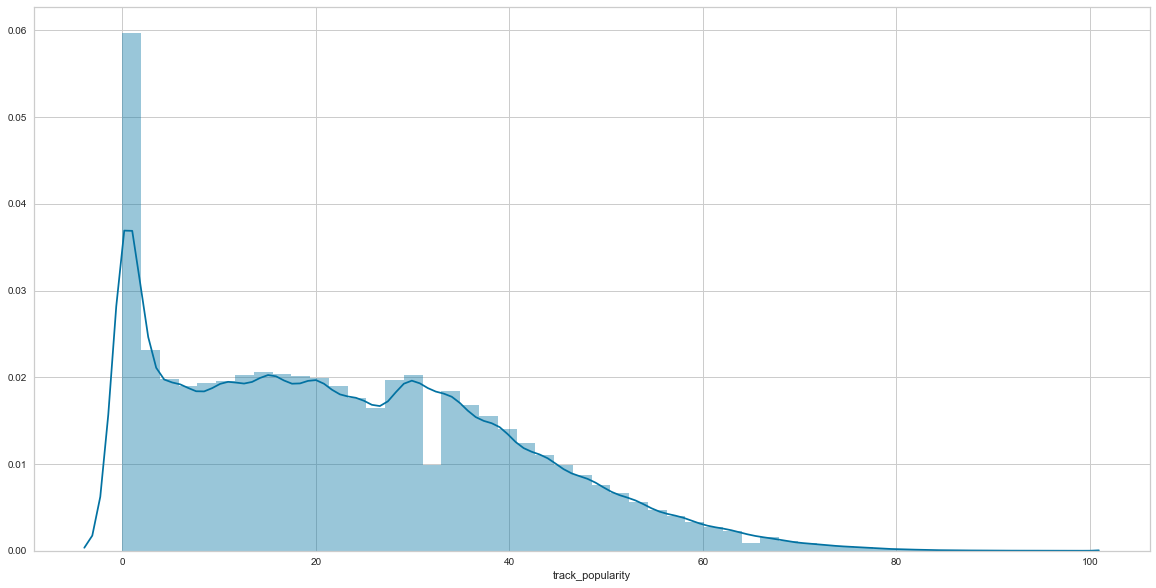

In [489]:
fig = plt.figure(figsize=(20,10))
sns.distplot(y1_train)
plt.show()

#### f) Normalize X Train & Test

In [243]:
# Normalize X_train & X_test
scaler = StandardScaler()

X1_train_norm = scaler.fit_transform(X1_train)
X1_test_norm = scaler.transform(X1_test)

#### g) Run Linear Regression

In [244]:
reg1 = sm.OLS(y1_train, X1_train_norm).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       track_popularity   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              937.2
Date:                Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
Time:                        13:17:01   Log-Likelihood:                     -2.4300e+06
No. Observations:              509812   AIC:                                  4.860e+06
Df Residuals:                  509803   BIC:                                  4.860e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6770      0.041    -16.655      0.000      -0.757      -0.597
x2             1.9468      0.041     47.891      0.000       1.867       2.027
x3            -0.0148      0.040     -0.366      0.714      -0.094       0.064
x4             0.0035      0.041      0.086      0.931      -0.076       0.083
x5            -1.3154      0.041    -31.859      0.000      -1.396      -1.234
x6            -0.9206      0.042    -21.809      0.000      -1.003      -0.838
x7            -2.2077      0.043    -50.780      0.000      -2.293      -2.122
x8            -0.0356      0.041     -0.873      0.383      -0.116       0.044
x9             0.0166      0.043      0.388      0.698      -0.067       0.101
==============================================================================
Omnibus:                    22804.296   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23441.965
Skew:                           0.493   Prob(JB):                         0.00
Kurtosis:                       2.635   Cond. No.                         1.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### h) QQ Plot

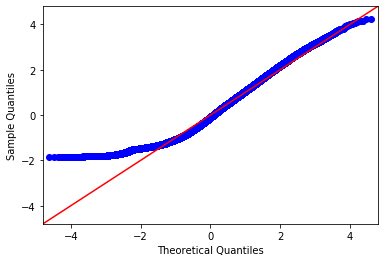

In [245]:
residuals = reg1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

### 2. Linear Regression w/ Binned Dependent Variable

#### i) Binning Independent Variable & Creating New DataFrame

In [142]:
# Create new dataframe
songs2 = songs1.copy()

In [143]:
# Bin independent variable
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 100]
#labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
songs2['track_popularity_bins'] = pd.cut(songs1['track_popularity'], bins=bins, labels=labels)

In [144]:
# Drop 0 popularity
songs2.dropna(inplace=True)

In [145]:
# Encoding categorical data
le = LabelEncoder()
songs2['track_popularity'] = le.fit_transform(songs2['track_popularity'])

In [146]:
# Independent variable value counts
songs2.track_popularity_bins.value_counts()

10     131599
20     124880
30     115033
40     104735
50      61421
60      30220
70      11257
80       2947
90        413
100        31
Name: track_popularity_bins, dtype: int64

#### j) Re-define X & Y

In [246]:
#Define appropriate X and y
X2 = songs2[songs2.columns[1:-1]]
y2 = songs2.track_popularity_bins

#### k) Train-Test Split

In [249]:
# Train-Test Split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .2)

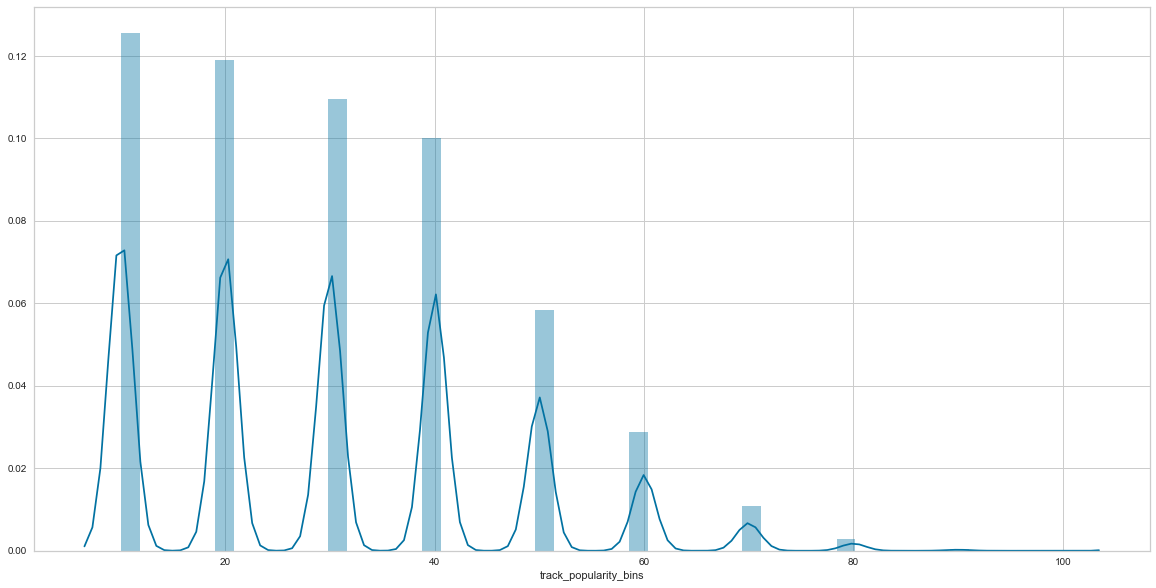

In [490]:
fig = plt.figure(figsize=(20,10))
sns.distplot(y2_train)
plt.show()

#### l) Normalize X Train & Test

In [250]:
# Normalize X_train & X_test
scaler = StandardScaler()

X2_train_norm = scaler.fit_transform(X2_train)
X2_test_norm = scaler.transform(X2_test)

#### m) Run Linear Regression

In [251]:
reg2 = sm.OLS(y2_train, X2_train_norm).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     track_popularity_bins   R-squared (uncentered):                   0.009
Model:                               OLS   Adj. R-squared (uncentered):              0.009
Method:                    Least Squares   F-statistic:                              462.6
Date:                   Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
Time:                           13:18:10   Log-Likelihood:                     -2.3030e+06
No. Observations:                 466028   AIC:                                  4.606e+06
Df Residuals:                     466019   BIC:                                  4.606e+06
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4648      0.051     -9.181      0.000      -0.564      -0.366
x2             1.7579      0.051     34.693      0.000       1.659       1.857
x3            -0.0083      0.050     -0.166      0.868      -0.107       0.090
x4            -0.0706      0.051     -1.395      0.163      -0.170       0.029
x5            -1.0167      0.051    -19.751      0.000      -1.118      -0.916
x6            -0.9451      0.053    -17.920      0.000      -1.048      -0.842
x7            -1.8705      0.054    -34.448      0.000      -1.977      -1.764
x8            -0.1617      0.051     -3.175      0.001      -0.261      -0.062
x9            -0.0339      0.054     -0.633      0.527      -0.139       0.071
==============================================================================
Omnibus:                    22636.206   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25288.786
Skew:                           0.557   Prob(JB):                         0.00
Kurtosis:                       2.753   Cond. No.                         1.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### n) QQ Plot

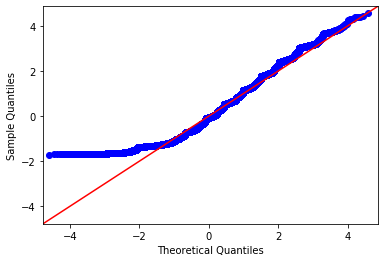

In [252]:
residuals = reg2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

#### o) ASK MURAT

Text(0.5, 1.0, 'Linear Relationship Exists')

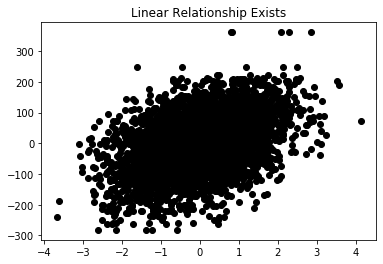

In [191]:
from sklearn.datasets.samples_generator import make_regression
X1, y1 = make_regression(n_samples=1000, n_features=5, noise=10)

plt.plot(X1, y1, 'o', color='black');
plt.title("Linear Relationship Exists")

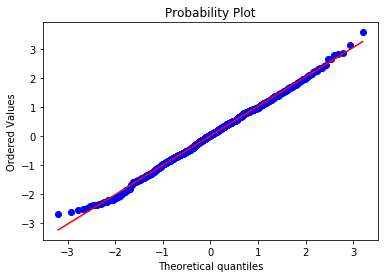

In [192]:
import scipy.stats as stats

stats.probplot(X1[:,0], dist="norm", plot=plt)
plt.show()

In [ ]:
# Ridge Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 100, 1000]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

## III. Logistic Regression

### 1. Create New DataFrame w/ Binary Dependent Variable  

#### a) Copy DataFrame

In [449]:
# Create new dataframe
songs3 = songs1.copy()

#### b) Create Binary Dependent Variable Column

In [450]:
# Create binary column for track_popularity over/under 50
songs3['track_popularity_50'] = np.where(songs3['track_popularity']>50, 1, 0)

#### d) Define X & Y

In [451]:
#Define appropriate X and y
X3 = songs3[songs3.columns[1:-1]]
y3 = songs3.track_popularity_50

#### c) Train-Test Split

In [452]:
# Train-Test Split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, 
                                                        stratify = y3,
                                                        test_size = .2)

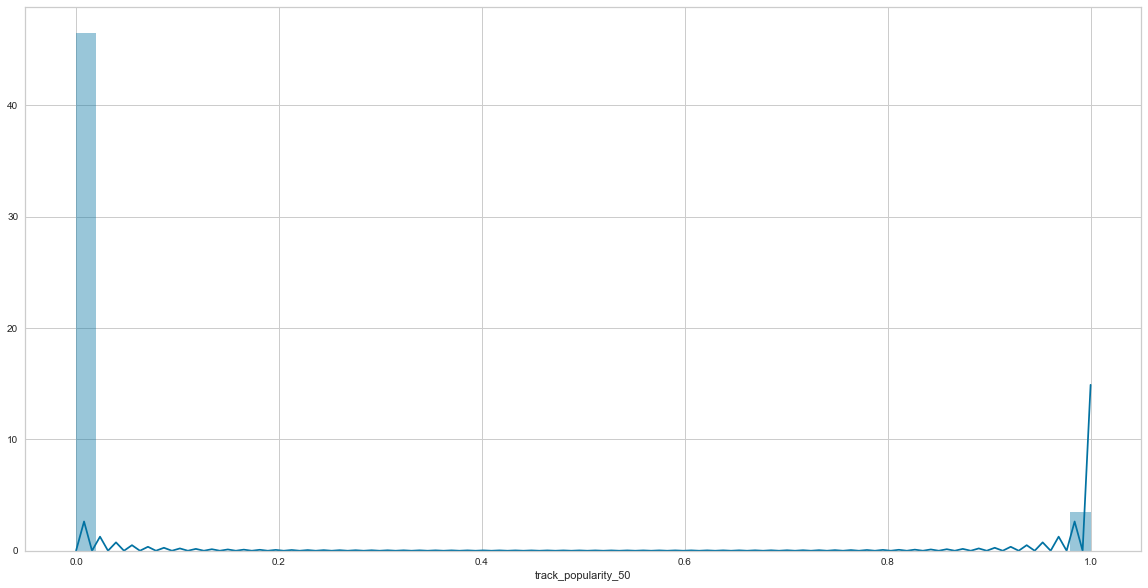

In [491]:
fig = plt.figure(figsize=(20,10))
sns.distplot(y3_train)
plt.show()

#### d) Normalize X_train & X_test

In [453]:
# Normalize X_train & X_test
scaler = StandardScaler()
X3_train_norm = scaler.fit_transform(X3_train)
X3_test_norm = scaler.transform(X3_test)

#### e) Identify Data Imbalance

In [454]:
# Identify data imbalance
y3_train.value_counts()

0    473918
1     35894
Name: track_popularity_50, dtype: int64

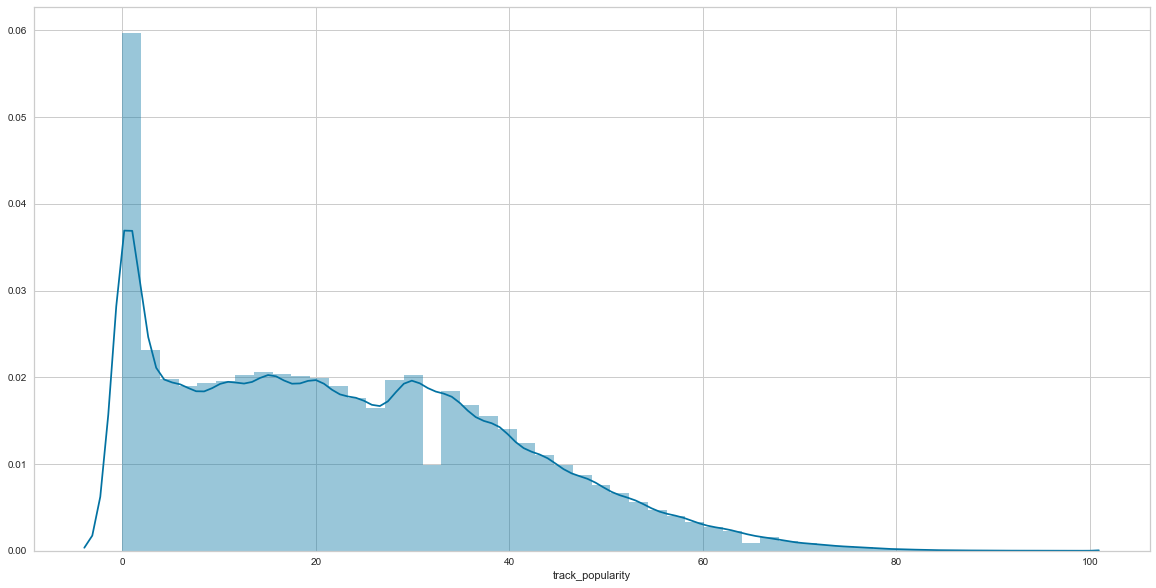

In [488]:
#Plot distributions of each genre 
fig = plt.figure(figsize=(20,10))
sns.distplot(y1_train)
plt.show()

### 2. Run Baseline Logistic Regression

In [470]:
lr1 = LogisticRegression(solver='liblinear').fit(X3_train_norm, y3_train)
lr1_pred = lr1.predict(X3_test_norm)

In [471]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, lr1_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, lr1_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, lr1_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, lr1_pred))

Accuracy: 0.9295897311165685
Precision: 0.0
F1: 0.0
Recall: 0.0


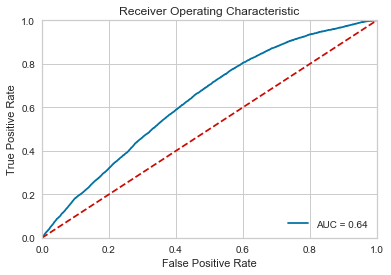

In [472]:

y_hat_test = lr1.predict(X3_test_norm)
y_score = lr1.decision_function(X3_test_norm)

fpr, tpr, threshold = roc_curve(y3_test, y_score)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3. Balancing Imbalanced Data

#### a) Method 1: Oversample Minority Class

In [415]:
# Convert Numpy array to DataFrame
X3_train_norm_df = pd.DataFrame(X3_train_norm)

In [416]:
# concatenate our training data back together
X3_train_norm_df = X3_train_norm_df.reset_index()
y3_train = y3_train.reset_index()
X4 = pd.concat([X3_train_norm_df, y3_train], axis=1, ignore_index=True)

In [418]:
# separate minority and majority classes
not_popular = X4[X4[11]==0]
popular = X4[X4[11]==1]

# upsample minority
popular_upsampled = resample(popular,
                          replace=True, # sample with replacement
                          n_samples=len(not_popular), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_popular, popular_upsampled])

# check new class counts
upsampled[11].value_counts()

1    473918
0    473918
Name: 11, dtype: int64

In [419]:
y4_train = upsampled[upsampled.columns[-1:]]
X4_train = upsampled[upsampled.columns[1:-2]]

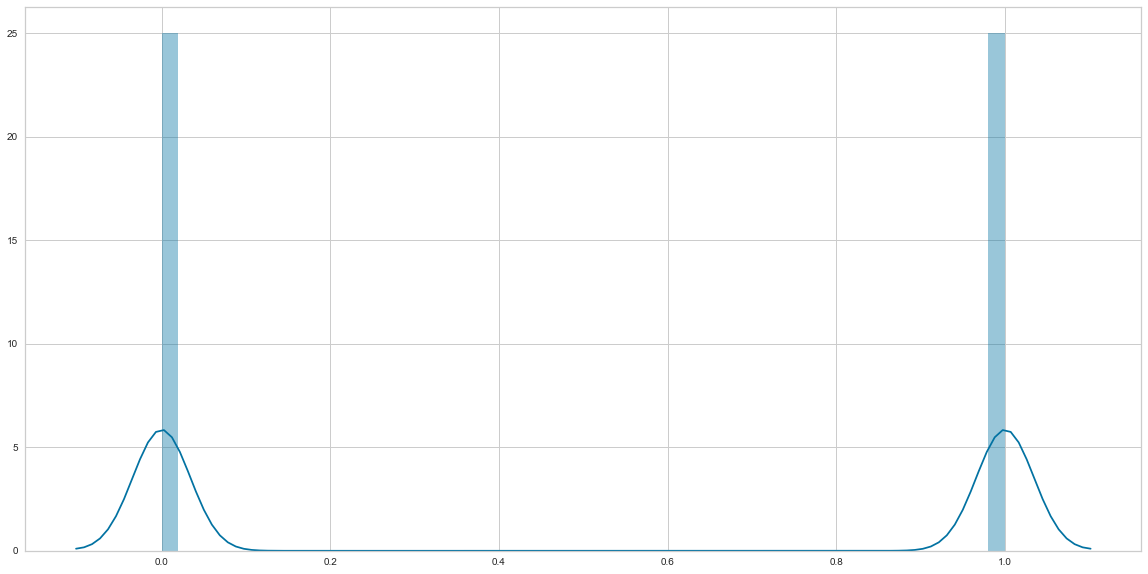

In [494]:
fig = plt.figure(figsize=(20,10))
sns.distplot(y4_train)
plt.show()

In [442]:
upsampled_lr = LogisticRegression(solver='liblinear').fit(X4_train, y4_train)
upsampled_pred = upsampled_lr.predict(X3_test_norm)

In [443]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, upsampled_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, upsampled_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, upsampled_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, upsampled_pred))

Accuracy: 0.47304496559516057
Precision: 0.09359110465441135
F1: 0.16633152106452173
Recall: 0.7466012926231335


#### b) Method 2: Undersample Majority Class

In [423]:
# still using our separated classes popular and not_popular from above

# downsample majority
not_popular_downsampled = resample(not_popular,
                                replace = False, # sample without replacement
                                n_samples = len(popular), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_popular_downsampled, popular])

# checking counts
downsampled[11].value_counts()

1    35894
0    35894
Name: 11, dtype: int64

In [426]:
y5_train = downsampled[downsampled.columns[-1:]]
X5_train = downsampled[downsampled.columns[1:-2]]

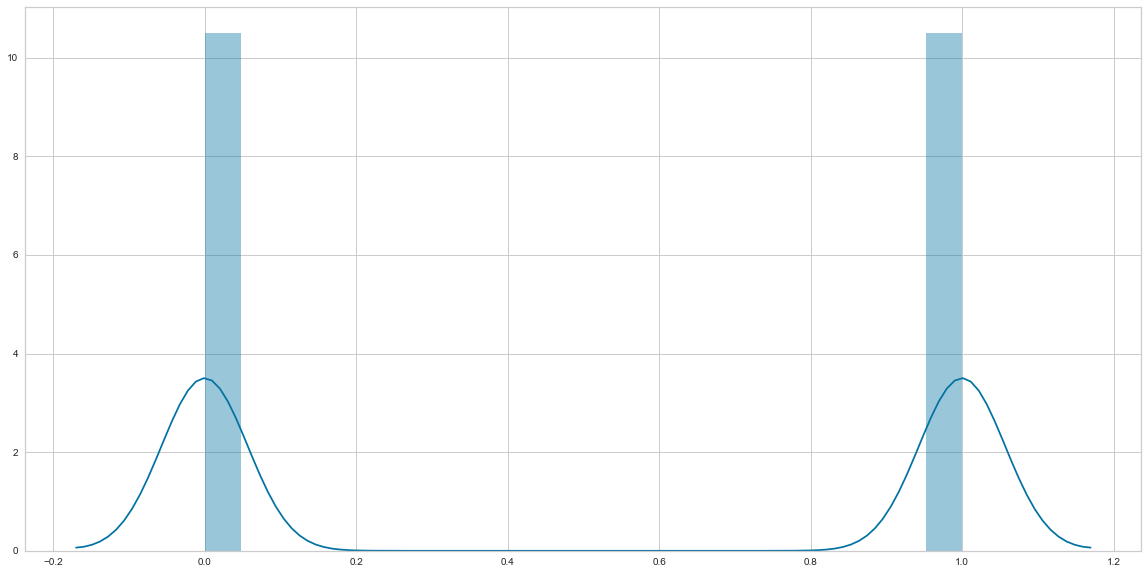

In [493]:
fig = plt.figure(figsize=(20,10))
sns.distplot(y5_train)
plt.show()

In [444]:
downsampled_lr = LogisticRegression(solver='liblinear').fit(X5_train, y5_train)
downsampled_pred = downsampled_lr.predict(X3_test_norm)

In [445]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, downsampled_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, downsampled_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, downsampled_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, downsampled_pred))

Accuracy: 0.475877382250712
Precision: 0.09348330404217926
F1: 0.1660195508058777
Recall: 0.7409182081568977


#### c) Method 3: Generate Synthetic Samples with SMOTE

In [456]:
print(y3_train.value_counts())
smote = SMOTE()
X3_train_norm_resampled, y3_train_resampled = smote.fit_sample(X3_train_norm, y3_train) 
print(pd.Series(y3_train_resampled).value_counts())

0    473918
1     35894
Name: track_popularity_50, dtype: int64
1    473918
0    473918
dtype: int64


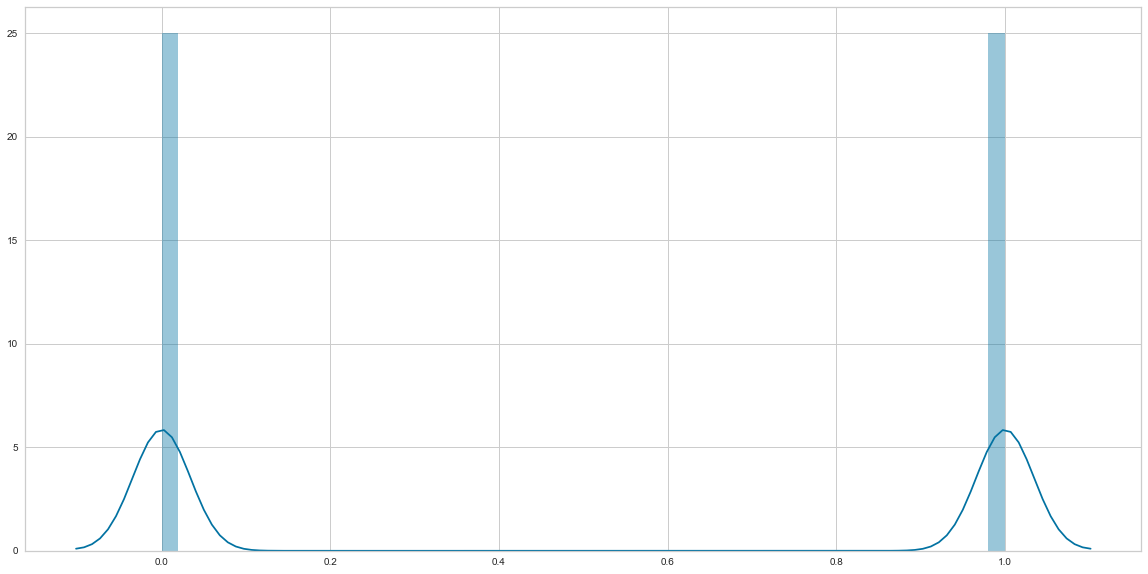

In [492]:
fig = plt.figure(figsize=(20,10))
sns.distplot(y3_train_resampled)
plt.show()

In [457]:
smote = LogisticRegression(solver='liblinear').fit(X3_train_norm_resampled, y3_train_resampled)
smote_pred = smote.predict(X3_test_norm)

In [458]:
# Checking Accuracy
print('Accuracy:', accuracy_score(y3_test, smote_pred))

# Checking Precision
print('Precision:', precision_score(y3_test, smote_pred))
    
# F1 Score
print('F1:', f1_score(y3_test, smote_pred))

# Checking Recall
print('Recall:', recall_score(y3_test, smote_pred))

Accuracy: 0.4851200050214589
Precision: 0.09455919611800576
F1: 0.1675905371979451
Recall: 0.7361265879206597


##### ROC CURVE

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.6369250954533805
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.25: 0.6368616350869964
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=

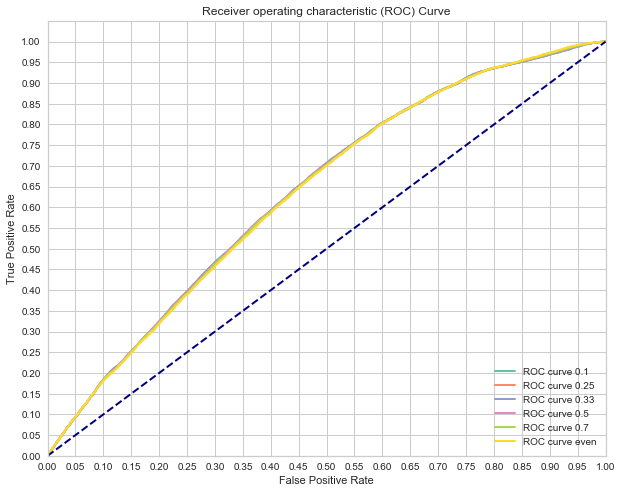

In [461]:
# Compare a few different ratios of minority class to majority class
ratios = [0.1,0.25, 0.33, 0.5,0.7,1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, ratio in enumerate(ratios):
    #Fit a model
    smote = SMOTE(sampling_strategy=ratio) # SMOTE
    X3_train_norm_resampled, y3_train_resampled = smote.fit_sample(X3_train_norm, y3_train) 
    logreg = LogisticRegression(fit_intercept = False, C = 1e12,solver ='lbfgs') #Starter code
    model_log = logreg.fit(X3_train_norm_resampled, y3_train_resampled)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X3_test_norm)

    y_score = logreg.decision_function(X3_test_norm)

    fpr, tpr, thresholds = roc_curve(y3_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 4. Cross Validation

In [505]:
#split into 10 stratified
cv = StratifiedKFold(n_splits= 10, random_state=1019, shuffle=True)

#pick sections to compare
lr_vanilla = LogisticRegression(C = 1e9, 
                                solver = 'newton-cg',
                                max_iter=1000)

l2_reg = LogisticRegression(C = 1, 
                            solver = 'newton-cg',
                            max_iter=1000)

l1_reg = LogisticRegression(C = 1, 
                           solver= 'saga', 
                           penalty = 'l1',
                            max_iter=1000)

#cross validations (each has different methods)
cv_vanilla = cross_validate(estimator=lr_vanilla, 
                            X = X3_train_norm_resampled, y = y3_train_resampled,
                            cv = cv, 
                            n_jobs=-1, 
                            return_estimator= True, 
                            return_train_score=True)

cv_l2 = cross_validate(estimator=l2_reg, 
                    X = X3_train_norm_resampled, y = y3_train_resampled,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)

cv_l1 = cross_validate(estimator=l1_reg, 
                    X = X3_train_norm_resampled, y = y3_train_resampled,
                    cv = cv, 
                    n_jobs=-1, 
                    return_estimator= True, 
                    return_train_score=True)


In [506]:
vanilla_result = np.concatenate((cv_vanilla['train_score'].reshape(-1,1), 
                cv_vanilla['test_score'].reshape(-1,1)), axis=1)

l2_result = np.concatenate((cv_l2['train_score'].reshape(-1,1), 
                cv_l2['test_score'].reshape(-1,1)), axis=1)

l1_result = np.concatenate((cv_l1['train_score'].reshape(-1,1), 
                cv_l1['test_score'].reshape(-1,1)), axis=1)

In [633]:
print('Vanilla Result:')
print(vanilla_result)
print('L2 Result:')
print(l2_result)
print('L1 Result:')
print(l1_result)

Vanilla Result:
[[0.60414137 0.60645257]
 [0.60450125 0.6042159 ]
 [0.60431134 0.60569294]
 [0.60474977 0.60195814]
 [0.60424687 0.60483837]
 [0.60452704 0.604237  ]
 [0.6042539  0.60541864]
 [0.60462082 0.60301317]
 [0.60441074 0.60478783]
 [0.60453852 0.60337406]]
L2 Result:
[[0.60414137 0.60645257]
 [0.60450125 0.6042159 ]
 [0.60431134 0.60568239]
 [0.60474977 0.60195814]
 [0.60424687 0.60483837]
 [0.60452821 0.604237  ]
 [0.60425507 0.60541864]
 [0.60462082 0.60301317]
 [0.60441191 0.60478783]
 [0.60453852 0.60337406]]
L1 Result:
[[0.60414137 0.60645257]
 [0.60449773 0.60422645]
 [0.60431486 0.60569294]
 [0.60475094 0.60194759]
 [0.6042457  0.60483837]
 [0.60452821 0.604237  ]
 [0.60425156 0.60542919]
 [0.60462082 0.60301317]
 [0.60441074 0.60480893]
 [0.60454086 0.60337406]]


In [582]:
print(vanilla_result.mean(axis=0), l1_result.mean(axis=0), l2_result.mean(axis=0))

print(vanilla_result.std(axis=0), l1_result.std(axis=0), l2_result.std(axis=0))

[0.60443016 0.60439886] [0.60443028 0.60440203] [0.60443051 0.60439781]
[0.0001809 0.0012753] [0.0001813  0.00127868] [0.00018083 0.00127423]


In [520]:
lr = cv_l2['estimator'][0]
lr.score(X3_train_norm_resampled, y3_train_resampled)

0.6043724863795003

### Confusion Matrix

NameError: name 'y3_pred' is not defined

In [ ]:
predictions = clf.predict(X3_train)
actual = y3_test

In [ ]:
confusion_matrix(actual, predictions)

In [ ]:
pd.DataFrame(confusion_matrix(actual, predictions), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

In [ ]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [ ]:
#We could subtract the two columns. If values or equal, difference will be zero. Then count number of zeros.
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))
# classifier about 85% correct for training data
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))
# classifier about 80% accurate for test data

## Random Forrest

#### Random Forrest

In [577]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# train model
rfc = RandomForestClassifier(n_estimators=9).fit(X3_train, y3_train)

#predict on test set
rfc_pred = rfc.predict(X3_test)

[0 0 0 ... 0 0 0]


In [578]:
# Checking Accuracy
print('Accuracy:', metrics.accuracy_score(y3_test, rfc_pred))

# Checking Precision
print('Precision:', metrics.precision_score(y3_test, rfc_pred))
    
# F1 Score
print('F1:', metrics.f1_score(y3_test, rfc_pred))

# Checking Recall
print('Recall:', metrics.recall_score(y3_test, rfc_pred))

Accuracy: 0.9272123841729892
Precision: 0.12406947890818859
F1: 0.010664391596459424
Recall: 0.005571651437486071


In [589]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y3_test, rfc_pred)
cm

array([[118126,    353],
       [  8924,     50]])

In [590]:
pd.DataFrame(confusion_matrix(y3_test, rfc_pred), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,118126,353
actual 1,8924,50


#### Random Forrest w/ Cross Validation

In [557]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = RandomForestClassifier() #Initialize with whatever parameters you want to

# 10-Fold Cross validation
clf_pred = np.mean(cross_val_score(clf, X3_train, 
                                   y3_train, cv=10))

In [558]:
clf_pred

0.9288914341510477

In [560]:
cv_model = cross_validate(clf, 
                          X3_train, 
                          y3_train, 
                          cv=10, 
                          return_estimator=True)

In [611]:
y_test_pred = cv_model['estimator'][i].predict(X3_test)
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [614]:
y_test_pred = []
for i in range(9):
    y_test_pred.append(cv_model['estimator'][i].predict(X3_test))

In [629]:
np.mean(y_test_pred)

0.0010783931680262092

In [625]:
# Checking Accuracy
y_test_pred_accuracy = []
for i in range(9):
    y_test_pred_accuracy.append(metrics.accuracy_score(y3_test, y_test_pred[i]))
print('Accuracy:', np.mean(y_test_pred_accuracy))

# Checking Precision
y_test_pred_precision= []
for i in range(9):
    y_test_pred_precision.append(metrics.precision_score(y3_test, y_test_pred[i]))
print('Precision:', np.mean(y_test_pred_precision))
    
# F1 Score
y_test_pred_f1 = []
for i in range(9):
    y_test_pred_f1.append(metrics.f1_score(y3_test, y_test_pred[i]))
print('F1:', np.mean(y_test_pred_f1))

# Checking Recall
y_test_pred_recall = []
for i in range(9):
    y_test_pred_recall.append(metrics.recall_score(y3_test, y_test_pred[i]))
print('Recall:', np.mean(y_test_pred_recall))

Accuracy: 0.9288617939336243
Precision: 0.1611861002660065
F1: 0.00490136554397878
Recall: 0.0024886709754104452


In [591]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y3_test, y_test_pred)
cm

array([[118370,    109],
       [  8954,     20]])

In [592]:
pd.DataFrame(confusion_matrix(y3_test, y_test_pred), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,118370,109
actual 1,8954,20


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn import tree

export_graphviz(tree_in_forest,
                feature_names=X.columns,
                filled=True,
                rounded=True)


In [631]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(y_test_pred[0], out_file='tree.dot', 
                feature_names = X3_train.columns,
                class_names = 'track_popularity',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

TypeError: [0 0 0 ... 0 0 0] is not an estimator instance.